<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Experiments/3_category_experiments/3_category_shallow_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Long Review Texts, 3 categories and Shallow Neural Network**

In this notebook we present a shallow neural network which utilizes BERT to classify customer review texts into three categories. The idea to use a shallow model came from the T-SNE plots which displayed a lot of overlap between the data when categorized into the 5 categories. By using 3 categories we hope to obtain a model which can understand sentiments more. Furthermore the longer review texts will be used in this model.

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.75.203.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.203.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Please make sure to have the nessecary files loaded onto your personal google drive as outlined in the readme file as this notebook will be utilizing such a method for getting the data, saving models and loading models. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we are loading in the data that will be used for this experiment.

In [ ]:
merged = pd.read_pickle('/content/drive/MyDrive/V13.plk')

In [ ]:
merged= merged.drop('reviewerID',axis=1)
merged=merged.drop('asin',axis=1)
merged=merged.drop('reviewerName',axis=1)
merged=merged.drop('summary',axis=1)
merged=merged.drop('unixReviewTime',axis=1)
merged=merged.drop('reviewTime',axis=1)

The next few cells will be taking a look at the data and preparing it for the training, validation, testing split.

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991159 entries, 7 to 7591158
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   helpful     object
 1   reviewText  object
 2   overall     int64 
dtypes: int64(1), object(2)
memory usage: 91.3+ MB


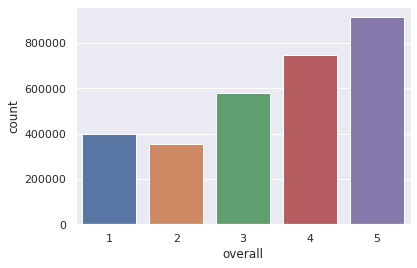

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=merged)

In [ ]:
np.random.seed(10)
remove_n = 200000

index_to_remove = merged[merged.overall == 4].index
drop_indices = np.random.choice(index_to_remove, remove_n, replace=False)
merged = merged.drop(drop_indices)

In [ ]:
np.random.seed(10)
remove_n = 300000

index_to_remove = merged[merged.overall == 5].index
drop_indices = np.random.choice(index_to_remove, remove_n, replace=False)
merged = merged.drop(drop_indices)

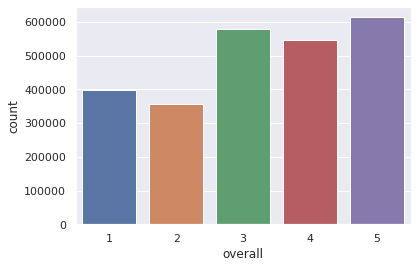

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=merged)

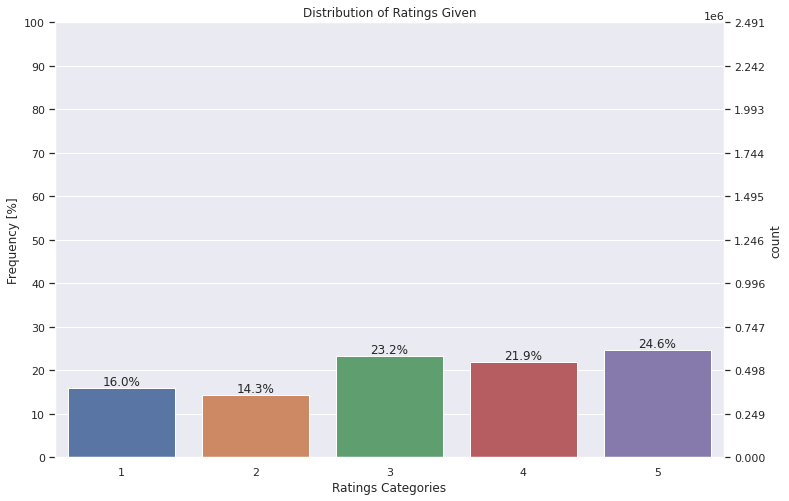

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=merged, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(merged)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

Here we group the data into three categories.

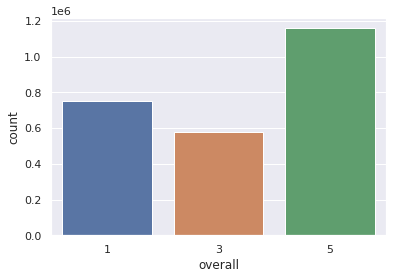

In [ ]:
for index, row in merged.iterrows():
    if row['overall'] == 2:
      merged.at[index,'overall'] = 1
    elif row['overall'] == 4:
      merged.at[index,'overall'] = 5

sns.set_theme()
ax = sns.countplot(x="overall", data=merged)

In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
merged = shuffle(merged)
merged.reset_index(inplace=True, drop=True)

In [ ]:
np.random.seed(10)
remove_n = 200000
index_to_remove = merged[merged.overall == 5].index
drop_indices = np.random.choice(index_to_remove, remove_n, replace=False)
merged = merged.drop(drop_indices)

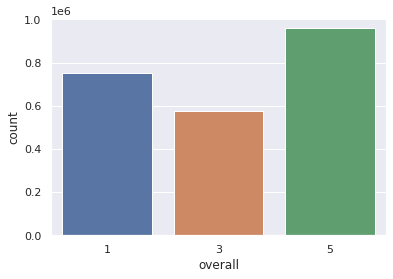

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=merged)

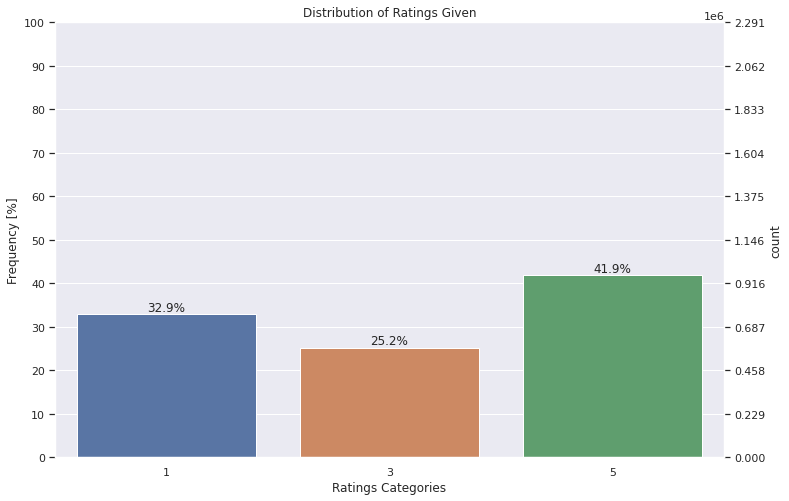

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=merged, order=[1,3,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(merged)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
# getting the 1's 
np.random.seed(10)
get_n = 30300
index_to_get = merged[merged.overall == 1].index
get_indices_a = np.random.choice(index_to_get, get_n, replace=False)
data_a = merged.loc[get_indices_a]


# getting the 3's
np.random.seed(10)
get_n = 23200
index_to_get = merged[merged.overall == 3].index
get_indices_b = np.random.choice(index_to_get, get_n, replace=False)
data_b = merged.loc[get_indices_b]

# getting the 5's
np.random.seed(10)
get_n = 46500
index_to_get = merged[merged.overall == 5].index
get_indices_c = np.random.choice(index_to_get, get_n, replace=False)
data_c = merged.loc[get_indices_c]



In [ ]:
drop_indicies = np.concatenate((get_indices_a,get_indices_b,get_indices_c),axis=0)
merged = merged.drop(drop_indicies, axis=0)

In [ ]:
new_data = pd.concat([data_a, data_b, data_c])

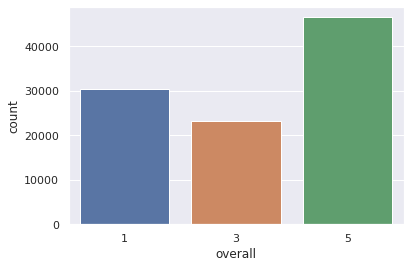

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=new_data)

In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
new_data = shuffle(new_data)
new_data.reset_index(inplace=True, drop=True)

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 71.7 MB/s 
     |████████████████████████████████| 895 kB 72.1 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 62.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


The categories will then be relabeled.

In [ ]:
for index, row in new_data.iterrows():
    if row['overall'] == 3:
       new_data.at[index,'overall'] = 2
    elif row['overall'] == 5:
      new_data.at[index,'overall'] = 3

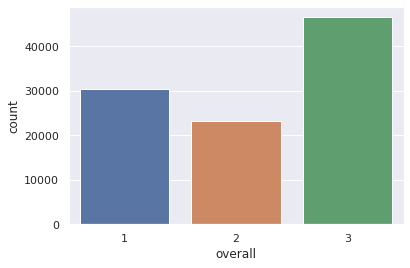

In [ ]:
sns.set_theme()
ax = sns.countplot(x="overall", data=new_data)

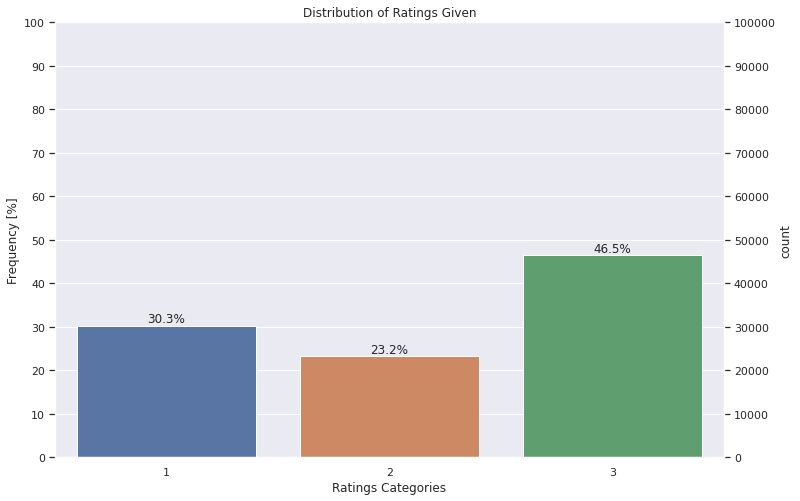

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="overall", data=new_data, order=[1,2,3])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(new_data)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
import sklearn


x = new_data.reviewText.values
y = new_data.overall.values


def data_split(examples, labels, train_frac = 0.8, random_state=None):


    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = sklearn.model_selection.train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = sklearn.model_selection.train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

x_train, x_val, x_test,  y_train, y_val, y_test = data_split(x,y,0.8,23)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
!pip install transformers

A BERT pre-trained model loaded in.

In [ ]:
from transformers import BertTokenizer, TFBertModel
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

The BERT encoding is done below.

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=512, padding="max_length", truncation=True) #try taking the first 128 and last 382 
    return tf.constant(tokens["input_ids"])


def batch_encoding(sentences):
    
    inputs   = tokenizer(sentences, padding=True, return_tensors='pt')
    print(inputs)
    outputs     = model(**inputs)
    features = outputs[0][:,0,:].detach().numpy()
    
    return features

train_encoded = bert_encode(x_train)
dev_encoded = bert_encode(x_val) 
test_encoded = bert_encode(x_test)

In [ ]:
y_train

array([5, 1, 5, ..., 5, 5, 3])

In [ ]:
train_labels = tf.keras.utils.to_categorical(y_train, num_classes=4)
dev_labels = tf.keras.utils.to_categorical(y_val, num_classes=4) # needs to be 6 max(y)+1
test_labels = tf.keras.utils.to_categorical(y_test, num_classes=4)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, train_labels))
    .shuffle(100)
    .batch(8)
).cache()
dev_dataset = (
    tf.data.Dataset.from_tensor_slices((dev_encoded, dev_labels))
    .shuffle(100)
    .batch(8)
).cache()

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_encoded, test_labels))
    .shuffle(100)
    .batch(8)
).cache()

In [ ]:
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
)

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
from tensorflow.keras import Model
from tensorflow_addons.optimizers import RectifiedAdam

In [ ]:
def bert_reviews_model():
  
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(
        shape=(512,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]
    pooled_output = Flatten()(last_hidden_states)
    net = Dropout(0.1)(pooled_output)
    net = Dense(512, kernel_regularizer= tf.keras.regularizers.L2(0.01), activity_regularizer= tf.keras.regularizers.L1(0.01),activation='relu')(net)

    output = Dense(4, activation="softmax")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

Below, you will see a summary of our model:

In [ ]:
with strategy.scope():
    model = bert_reviews_model()
    adam_optimizer = RectifiedAdam(learning_rate=2e-6)
    model.compile(
        loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"] 
    )
    model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             512),                               
                              (None, 12, None, 512),         

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=8,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
) 

Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 4) dtype=float32>]


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 4) dtype=float32>]


10000/10000 [==============================] - ETA: 0s - loss: 6.2323 - accuracy: 0.6765

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 4) dtype=float32>]


10000/10000 [==============================] - 1773s 168ms/step - loss: 6.2323 - accuracy: 0.6765 - val_loss: 1.2493 - val_accuracy: 0.7606
Epoch 2/3
10000/10000 [==============================] - 1665s 167ms/step - loss: 0.9256 - accuracy: 0.7692 - val_loss: 0.8470 - val_accuracy: 0.7713
Epoch 3/3
10000/10000 [==============================] - 1667s 167ms/step - loss: 0.7746 - accuracy: 0.7926 - val_loss: 0.8124 - val_accuracy: 0.7779


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

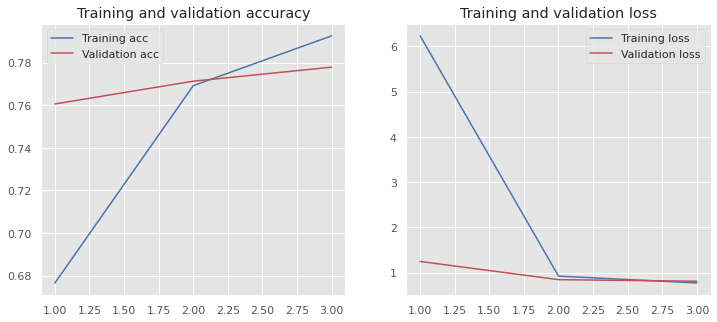

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_encoded, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred_bool))

In [ ]:
loss, accuracy = model.evaluate(test_dataset,verbose=False)

In [ ]:
accuracy

0.7835999727249146